In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Creating dataset

In [2]:
# Remove corrupted images
num_skipped = 0
folder_path = "Images"
for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    for race in os.listdir(fpath):
        img = os.path.join(fpath, race)
        try:
            fobj = open(img, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(img)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [116]:
import json
class_names = os.listdir("Images")
class_names.sort()
race_names = ['-'.join(name.split('-')[1:]).replace('_', ' ').title() for name in class_names]

out_race = open('race_names.json', 'w')
json.dump(race_names, out_race)
out_race.close()

In [19]:
image_size = (180, 180)
batch_size = 33

train_ds = keras.preprocessing.image_dataset_from_directory(
    "Images",
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    "Images",
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

# one-hot encoding
#train_data = train_data.map(lambda x, y: (x, tf.one_hot(y, depth=NUM_CLASSES)))
#val_data = val_data.map(lambda x, y: (x, tf.one_hot(y, depth=NUM_CLASSES)))

# Set buffered prefectching to minimize I/O
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 20570 files belonging to 120 classes.
Using 16456 files for training.
Found 20570 files belonging to 120 classes.
Using 4114 files for validation.


Found 20570 files belonging to 120 classes.
Using 16456 files for training.
Found 20570 files belonging to 120 classes.
Using 4114 files for validation.


TypeError: only size-1 arrays can be converted to Python scalars

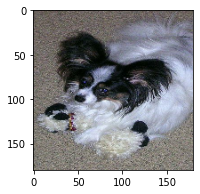

In [18]:
# Visualize images

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()

# Data augmentation

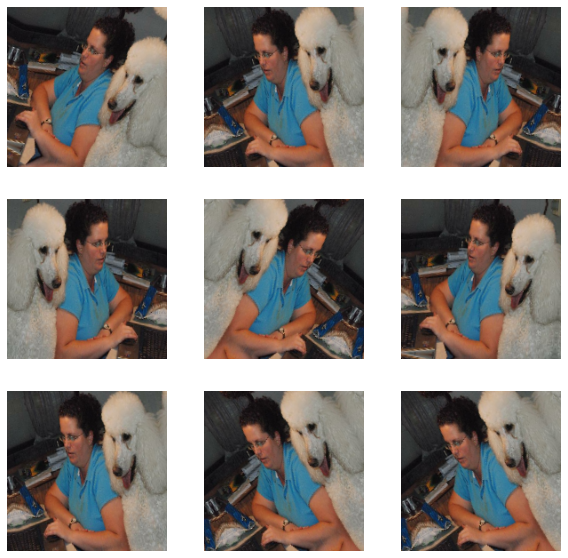

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


# Create model

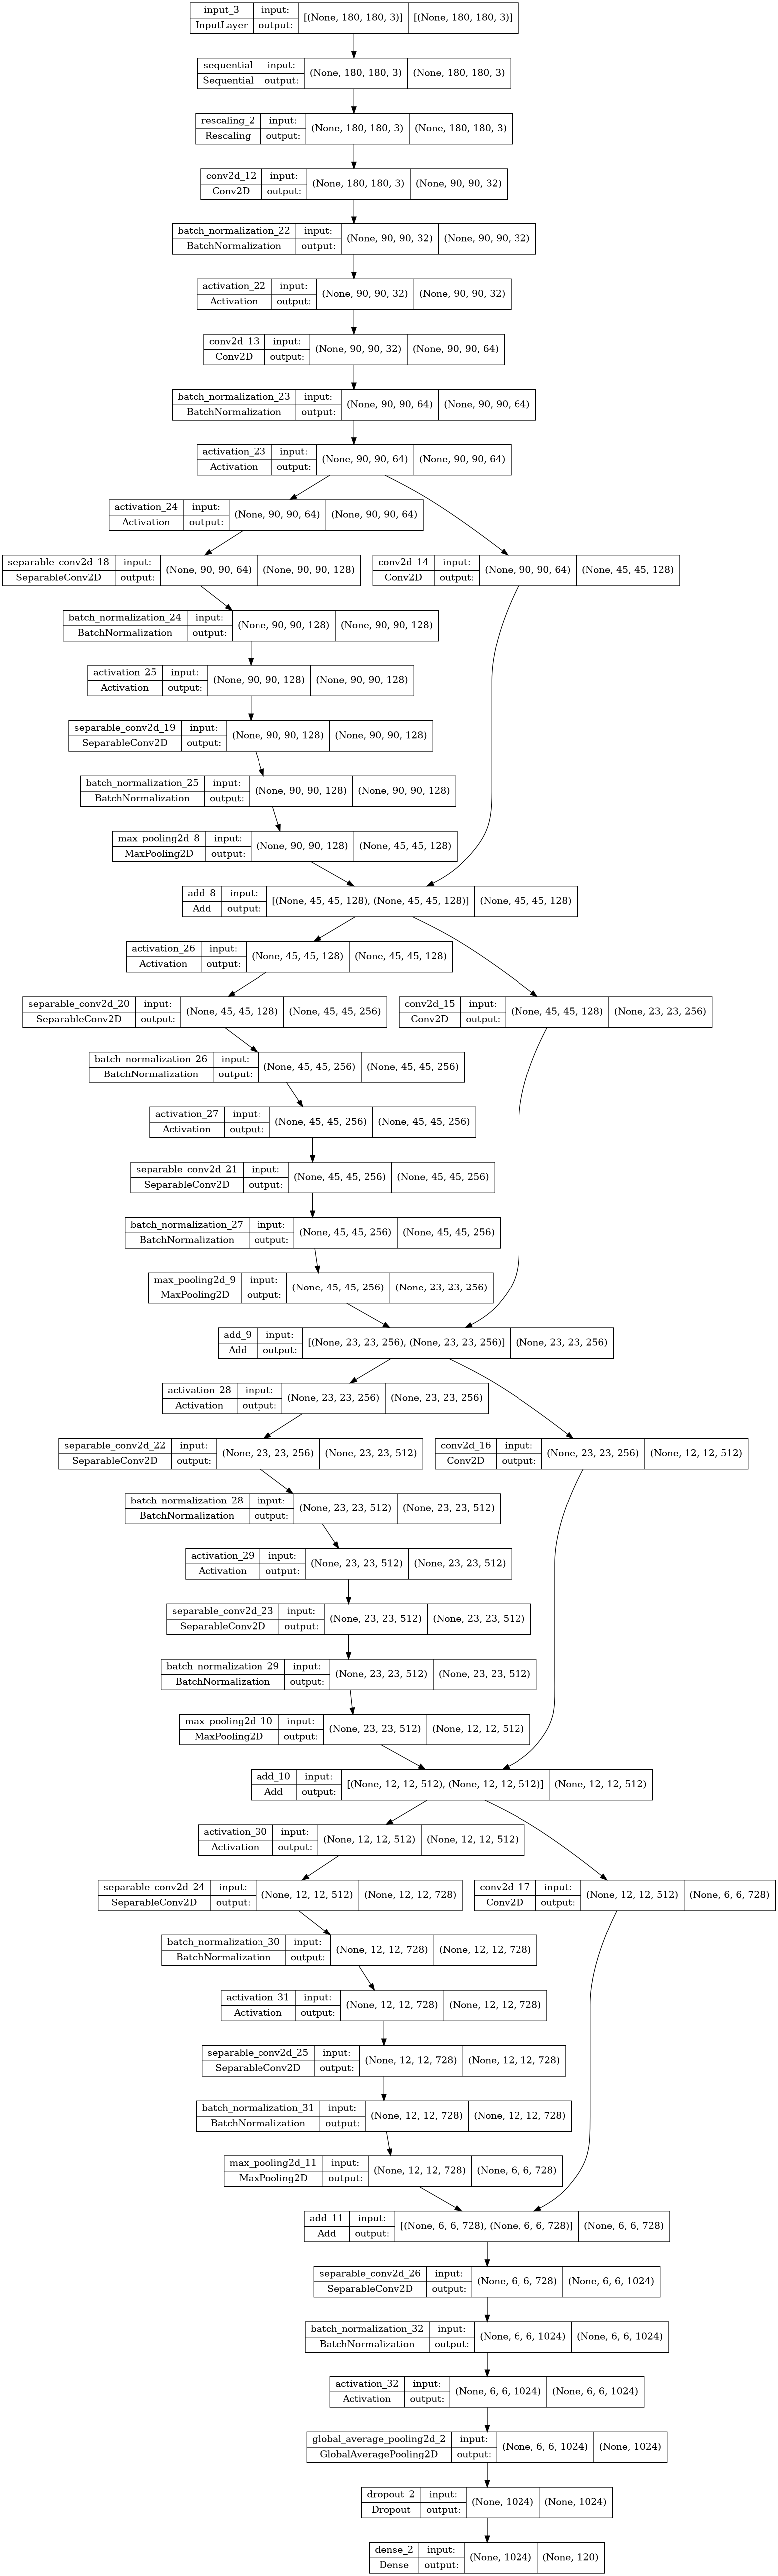

In [10]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=120)
keras.utils.plot_model(model, show_shapes=True)


# Train the model

In [17]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_3[0][0]']                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 180, 180, 3)  0           ['sequential[2][0]']             
                                                                                                  
 conv2d_12 (Conv2D)             (None, 90, 90, 32)   896         ['rescaling_2[0][0]']      

 batch_normalization_29 (BatchN  (None, 23, 23, 512)  2048       ['separable_conv2d_23[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 12, 12, 512)  0          ['batch_normalization_29[0][0]'] 
 )                                                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 12, 12, 512)  131584      ['add_9[0][0]']                  
                                                                                                  
 add_10 (Add)                   (None, 12, 12, 512)  0           ['max_pooling2d_10[0][0]',       
                                                                  'conv2d_16[0][0]']              
          

In [20]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
499/499 [==============================] - 68s 134ms/step - loss: 0.0536 - accuracy: 0.0215 - val_loss: 0.0509 - val_accuracy: 0.0153
Epoch 2/50
499/499 [==============================] - 67s 135ms/step - loss: 0.0445 - accuracy: 0.0492 - val_loss: 0.0429 - val_accuracy: 0.0654
Epoch 3/50
499/499 [==============================] - 67s 135ms/step - loss: 0.0420 - accuracy: 0.0812 - val_loss: 0.0449 - val_accuracy: 0.0496
Epoch 4/50
499/499 [==============================] - 67s 135ms/step - loss: 0.0396 - accuracy: 0.1176 - val_loss: 0.0442 - val_accuracy: 0.0690
Epoch 5/50
499/499 [==============================] - 68s 135ms/step - loss: 0.0373 - accuracy: 0.1534 - val_loss: 0.0394 - val_accuracy: 0.1485
Epoch 6/50
499/499 [==============================] - 67s 134ms/step - loss: 0.0354 - accuracy: 0.1891 - val_loss: 0.0420 - val_accuracy: 0.1006
Epoch 7/50
499/499 [==============================] - 67s 135ms/step - loss: 0.0332 - accuracy: 0.2405 - val_loss: 0.0383 - val_ac

In [111]:
model.save('naive_model')

2022-03-11 11:18:20.706047: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: naive_model/assets


In [119]:
img = keras.preprocessing.image.load_img(
    "jerome.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)

top4 = predictions.argsort()[0, -1:-5:-1]

for race, acc in zip(np.array(race_names)[top4], predictions[0, top4]):
    print(f'{race} at {acc:.2%}')

Lhasa at 82.53%
Shih-Tzu at 10.10%
Pug at 4.62%
French Bulldog at 2.26%
